In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

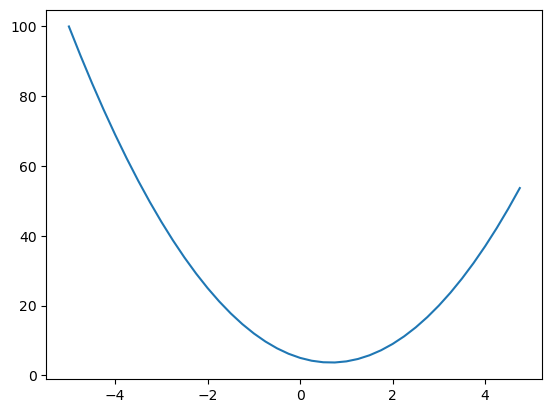

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
h = 0.00000001
x = -3.0
(f(x+h) - f(x))/h

-22.00000039920269

In [11]:
h = 0.00000001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
print('d1', d1)

a += h
d2 = a*b + c
print('d2', d2)

print('Slope: ', (d2-d1)/h)


d1 4.0
d2 3.99999997
Slope:  -2.999999981767587


In [104]:
class Value:
    # _children is a set of all the values that created this value
    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), '-')
    
    def __div__(self, other):
        return Value(self.data // other.data)
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        return Value(t, (self,), 'tanh')


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e' 

d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d*f; L.label = 'L'




In [78]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [79]:
d._op

'+'

In [80]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name=uid, label= "{%s | data: %.4f | grad: %4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label= n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

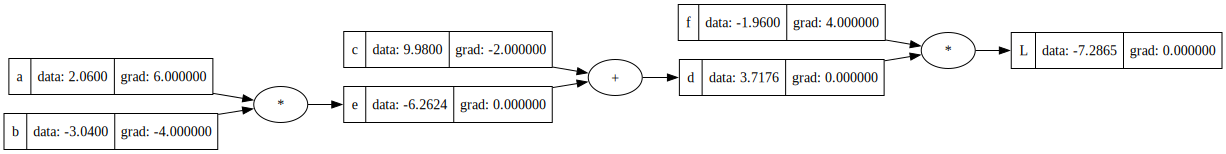

In [85]:
draw_dot(L)

# ***Inline gradient checker***

In [82]:
def foo():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f ; L.label = 'L'
    L2 = L.data

    return ((L2 - L1) / h)

foo()


-3.9999999999995595

In [83]:
L.grad = 1.0; d.grad = -2.0; f.grad = 4.0

c.grad = d.grad * 1.0; e.grad = d.grad * 1.0

a.grad = e.grad * b.data; b.grad = e.grad * a.data

In [102]:

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; e.label = 'e'
d =  c + e ; d.label = 'd'
L = d * f; L.label = 'L'

print(L.data)

2.326527999999995


In [107]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1.w1'
x2w2 = x2 * w2; x2w2.label = 'x2.w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1.w1 + x2.w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'




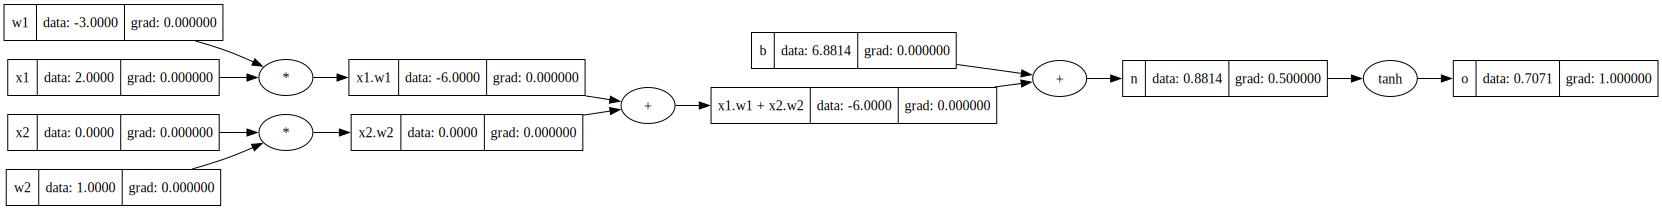

In [112]:
draw_dot(o)


In [109]:
o.grad = 1.0

In [111]:
n.grad = o.grad * (1 - o.data**2) # d/dn tanh(n) = 1 - tanh(n)^2S